In [55]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam

In [56]:
# Load your dataset
file_path = 'dataset/classData.csv'
data = pd.read_csv(file_path)

In [57]:
print("\nChecking for missing values:")
missing_values = data.isnull().sum()

# Checking for any duplicates
duplicate_rows = data.duplicated().sum()

missing_values,duplicate_rows


Checking for missing values:


(G     0
 C     0
 B     0
 A     0
 Ia    0
 Ib    0
 Ic    0
 Va    0
 Vb    0
 Vc    0
 dtype: int64,
 0)

In [58]:
data['Fault_Type'] = data[['G', 'C', 'B', 'A']].astype(str).agg(''.join, axis=1)

fault_types = {
    '0000': 'No Fault',
    '1001': 'Single Line to Ground A',
    '1010': 'Single Line to Ground B',
    '1100': 'Single Line to Ground C',
    '0110': 'Line-to-Line BC',
    '0101': 'Line-to-Line AC',
    '0011': 'Line-to-Line AB',
    '1011': 'Line-to-Line with Ground AB',
    '1101': 'Line-to-Line with Ground AC',
    '1110': 'Line-to-Line with Ground BC',
    '0111': 'Three-Phase',
    '1111': 'Three-Phase with Ground'
}

output = len(fault_types)

# Mapping fault type codes to fault type names
data['Fault_Type'] = data['Fault_Type'].map(fault_types)

# Counting the occurrences of each fault type
fault_type_counts = data['Fault_Type'].value_counts()
fault_type_counts

Fault_Type
No Fault                       2365
Line-to-Line with Ground AB    1134
Three-Phase with Ground        1133
Single Line to Ground A        1129
Three-Phase                    1096
Line-to-Line BC                1004
Name: count, dtype: int64

In [59]:
data.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,Single Line to Ground A
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,Single Line to Ground A
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,Single Line to Ground A
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,Single Line to Ground A
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,Single Line to Ground A


In [60]:
data.drop(['G','C','B','A'],axis=1,inplace = True)

In [61]:
data.head()

,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,Single Line to Ground A
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,Single Line to Ground A
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,Single Line to Ground A
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,Single Line to Ground A
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,Single Line to Ground A


In [62]:
# Descriptive statistics
print("\nDescriptive Statistics:")
data.describe()


Descriptive Statistics:


,Ia,Ib,Ic,Va,Vb,Vc
count,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000
mean,13.721194,-44.845268,34.392394,-0.007667,0.001152,0.006515
std,464.741671,439.269195,371.107412,0.289150,0.313437,0.307897
min,-883.542316,-900.526951,-883.357762,-0.620748,-0.608016,-0.612709
25%,-119.802518,-271.845947,-61.034219,-0.130287,-0.159507,-0.215977
50%,2.042805,5.513317,-4.326711,-0.005290,0.001620,0.009281
75%,227.246377,91.194282,49.115141,0.111627,0.153507,0.239973
max,885.738571,889.868884,901.274261,0.595342,0.627875,0.600179


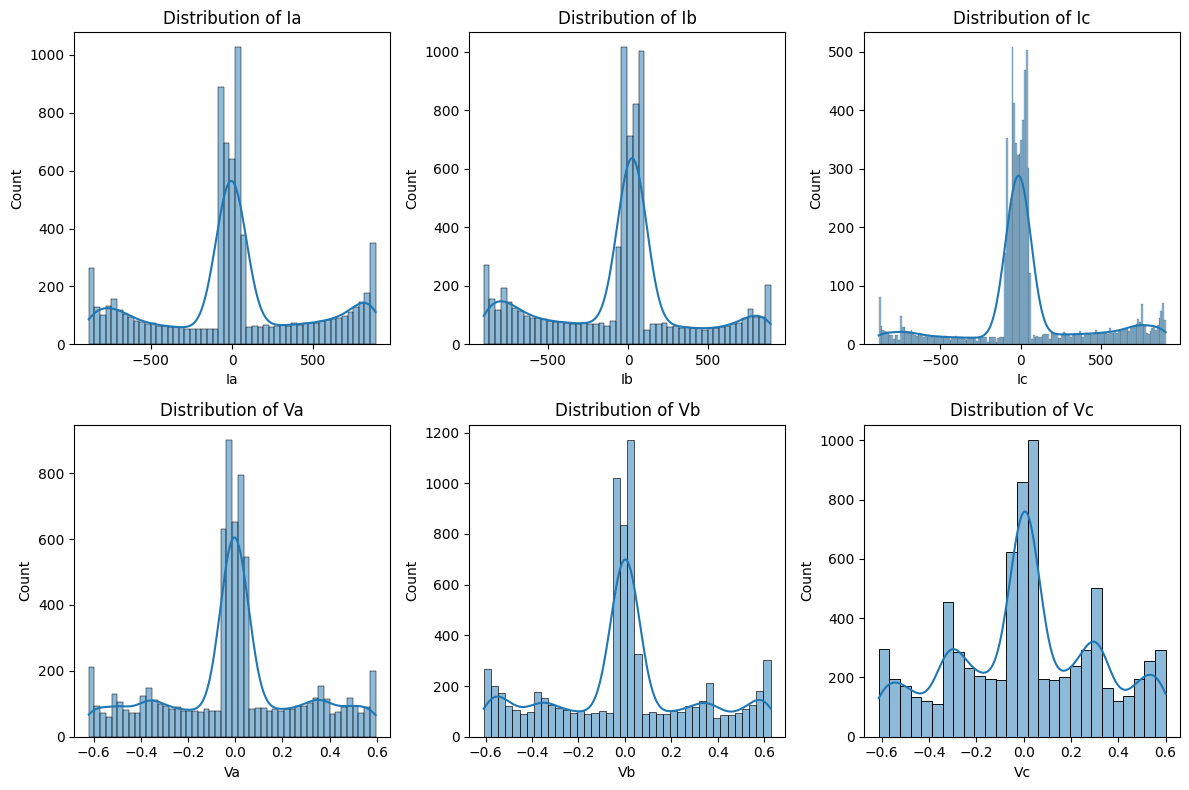

In [63]:
# Data Visualization: Histograms for each feature
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


Correlation Matrix:
          Ia        Ib        Ic        Va        Vb        Vc
Ia  1.000000 -0.374241 -0.276457  0.035682 -0.274612  0.246043
Ib -0.374241  1.000000 -0.528291  0.029118  0.032101 -0.060023
Ic -0.276457 -0.528291  1.000000 -0.069137 -0.056967  0.122919
Va  0.035682  0.029118 -0.069137  1.000000 -0.480247 -0.450225
Vb -0.274612  0.032101 -0.056967 -0.480247  1.000000 -0.566986
Vc  0.246043 -0.060023  0.122919 -0.450225 -0.566986  1.000000


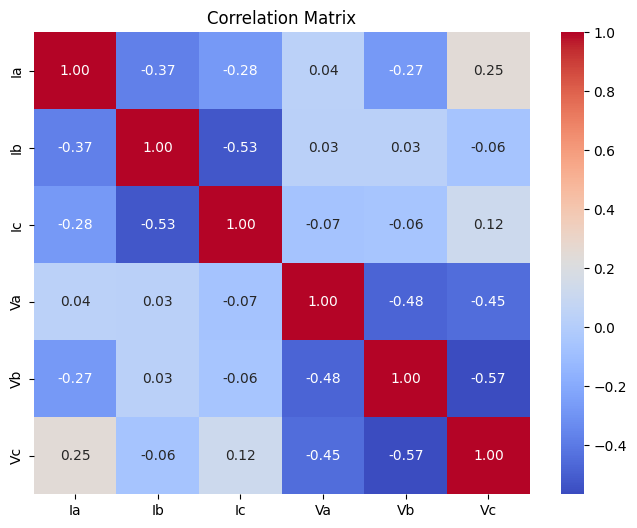

In [64]:
# Correlation matrix
print("\nCorrelation Matrix:")
correlation_matrix = data[features].corr()
print(correlation_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

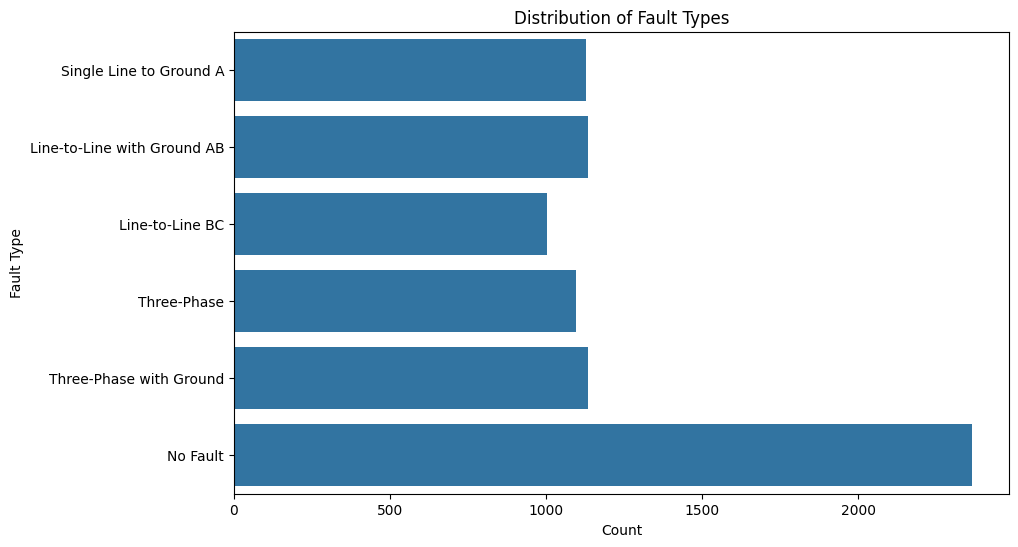

In [65]:
# Plotting the distribution of fault types
plt.figure(figsize=(10, 6))
sns.countplot(y=data['Fault_Type'])
plt.title('Distribution of Fault Types')
plt.xlabel('Count')
plt.ylabel('Fault Type')
plt.show()

In [66]:
# Normalization (using Min-Max Scaling as an example)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(data[features])

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the 'Fault_Type' to integer labels
y_encoded = label_encoder.fit_transform(data['Fault_Type'])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Convert to TensorFlow datasets if necessary
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6288, 6), (1573, 6), (6288,), (1573,))

In [67]:
# Define the neural network model
model = Sequential([
    Dense(512, activation='relu', input_dim=x_train.shape[1]), 
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(output, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_test, y_test), 
                    epochs=500)

Epoch 1/500


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2208 - loss: 2.3025 - val_accuracy: 0.3007 - val_loss: 1.8075
Epoch 2/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3037 - loss: 1.8050 - val_accuracy: 0.3007 - val_loss: 1.6360
Epoch 3/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3470 - loss: 1.6710 - val_accuracy: 0.3853 - val_loss: 1.4966
Epoch 4/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4066 - loss: 1.5269 - val_accuracy: 0.4990 - val_loss: 1.3395
Epoch 5/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4780 - loss: 1.3670 - val_accuracy: 0.5499 - val_loss: 1.1794
Epoch 6/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5173 - loss: 1.2390 - val_accuracy: 0.6230 - val_loss: 1.0399
Epoch 7/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5802 - loss: 1.1059 - val_accuracy: 0.6567 - val_loss: 0.9311
Epoch 8/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6079 - loss: 1.0089 - val_accuracy: 0.6891

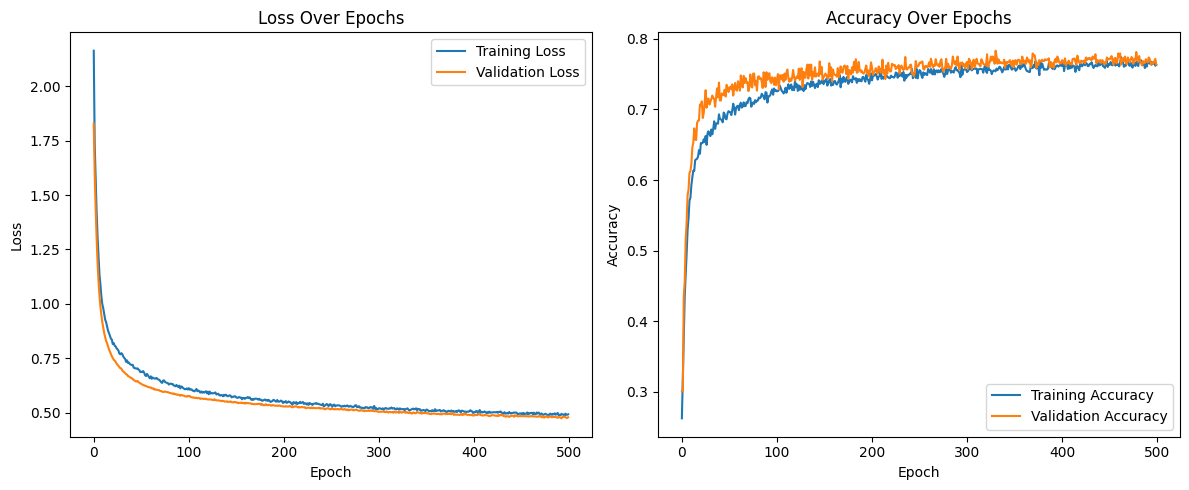

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [51]:
model.save('fault_classification_model.h5')

In [52]:
test_data = np.array([[-643.6636173,-224.1594274,-132.2828154,0.20953688,-0.095553751,-0.113983129]]) 
time_list = []
for i in range(0, 20):
    start_time = time.time()

    prediction = model.predict(test_data)

    predicted_class = (prediction > 0.5).astype(int)
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    time_list.append(elapsed_time)
    
    print("Prediction:", prediction)
    print("Predicted Class:", predicted_class)
    print("Time taken for prediction: {:.4f} seconds".format(elapsed_time))
# Print minimum time taken for prediction
print(f"Minimum time taken for prediction: {min(time_list):.4f} seconds")

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (1, 6)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 6), dtype=float32)
  • training=False
  • mask=None

In [ ]:
import time
# Example new input data
new_data = np.array([[-643.6636173,-224.1594274,-132.2828154,0.20953688,-0.095553751,-0.113983129]]) 
time_list = []

for i in range(0, 20):
    start_time = time.time()
    # Normalize the new input data
    new_data_scaled = scaler.transform(new_data)

    # Make a prediction
    prediction = model.predict(new_data_scaled)
    predicted_class = np.argmax(prediction, axis=1) 

    # Decode the predicted class
    predicted_fault_type = label_encoder.inverse_transform(predicted_class)
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    time_list.append(elapsed_time)

    print("Prediction:", prediction)
    print("Predicted Class:", predicted_fault_type)
    print("Time taken for prediction: {:.4f} seconds".format(elapsed_time))
# Print minimum time taken for prediction
print(f"Minimum time taken for prediction: {min(time_list):.4f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.1763 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.0763 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.0748 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.0767 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.0980 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.0774 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.999

c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.0837 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.1306 seconds


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.1030 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.1021 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.0972 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.1000 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.1095 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.1042 seconds


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.0958 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.1004 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.0756 seconds


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.0730 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction: [[1.6374305e-17 3.4708079e-05 1.9135598e-19 9.9996138e-01 8.8489907e-07
  3.1209311e-06 1.2405202e-21 2.1101959e-21 1.7731711e-21 2.6830294e-21
  2.2723891e-21 1.0500322e-21]]
Predicted Class: ['Single Line to Ground A']
Time taken for prediction: 0.0974 seconds
Minimum time taken for prediction: 0.0682 seconds


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:


# # Separate features and labels
# x = data[['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']].values
# y = data[['G', 'C', 'B', 'A']].values

# # Split the dataset into training and testing sets
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# # Convert to TensorFlow datasets if necessary
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)



In [ ]:
# # Define a dictionary to store the cross-validation metrics of the algorithms
# cv_metrics = {'Model': [], 'Accuracy': []}
# test_metrics = {'Model': [], 'Accuracy': []}

# # Define a function to train and evaluate each algorithm
# def train_and_evaluate_model(model, model_name, x_train, y_train):
#     # Define the scoring metrics for multi-class classification
#     scoring = {
#         'accuracy': make_scorer(accuracy_score),
#     }

#     # Perform cross-validation using StratifiedKFold
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_validate(model, x_train, y_train, cv=skf, scoring=scoring)
#         # Store the cross-validation metrics
#     cv_metrics['Model'].append(model_name)
#     cv_metrics['Accuracy'].append(scores['test_accuracy'].mean())
#     print(f"{model_name}: Cross-validation metrics calculated")
    
#     # Fit the model on the entire training set
#     model.fit(x_train, y_train)
#     return model

# # Define a function to evaluate the model on the test set and store the metrics
# def evaluate_on_test_set(model, model_name, x_test, y_test):
#     y_pred = model.predict(x_test)
#     test_metrics['Model'].append(model_name)
#     test_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
#     print(f"{model_name}: Test metrics calculated")

# # Train and evaluate each algorithm
# # models = [
# #     (MLPClassifier(random_state=42, max_iter=1000), "Neural Networks")
# # ]
# model = MLPClassifier(random_state=42, max_iter=1000)
# model_name = "Neural Networks"

# # # Train and evaluate each model
# # for model, model_name in models:
# fitted_model = train_and_evaluate_model(model, model_name, x_train, y_train)
# evaluate_on_test_set(fitted_model, model_name, x_test, y_test)

# # Convert the dictionary of cross-validation metrics to a DataFrame
# # import pandas as pd
# cv_metrics_df = pd.DataFrame(cv_metrics)
# test_metrics_df = pd.DataFrame(test_metrics)
# print("\nCross-validation Metrics:")
# print(cv_metrics_df)
# print("\nTest Metrics:")
# print(test_metrics_df)

In [ ]:
# # Evaluate the model
# loss, accuracy = model.evaluate(x_test, y_test)
# print(f'Test Loss: {loss}')
# print(f'Test Accuracy: {accuracy}')